<h2>
An Analysis of <i>The Lazy Fundamental Analyst</i>
</h2>
<p>
The book <i>The Lazy Fundamental Analyst</i> by Fred Piard proposes an investment strategy that utilizes fundamental factors
like Price Earnings (PE) and Return on Assets (ROA) to select stocks within a sector. This is combined with a market timing
signal based on S&P 500 earnings per share momentum and unemployment momentum. This notebook attempts to verify some of these
results.
</p>
<h3>
Market Timing Signals
</h3>
<h4>
EPS Estimate Momentum
</h4>
<blockquote>
<p>
"EPS Estimate Momentum" is an aggregate fundamental ratio over the S&P 500 Index. It gives a bearish signal when
the S&P 500 current year EPS estimate is below its own value three months previously, and a bullish signal when it is
above this value.
</p>
<p>
<i>The Lazy Fundamental Analyst</i> by Fred Paird
</p>
</blockquote>
<h4>
Unemployment Momentum
</h4>
<blockquote>
<p>
It [Unemployment Momentum] gives a bearish signal when the US enemployment rate is above it's own value three months ago,
and a bullish signal when it is below this value. The US unemployment rate is published once a month, usually in the first half
of the month for the previous month.
</p>
</blockquote>
<p>
When one of the indicators is "bullish", the portfolio is invested in stocks. When the two indicators are "bearish" the
portfolio is hedged with the ETF SH (ProShares 1x Short S&P 500).
</p>
<h3>
EPS Estimate Momentum
</h3>
<p>
Monthly S&P 500 earnings yield, by month, is published on the NASDAQ data site, along with several other S&P 500 statistics. See
<a href="https://data.nasdaq.com/data/MULTPL-sp-500-ratios">S&P 500 Ratios</a>. Fred Piard's EPS estimate momentum is the yearly
sum, so the estimate for 12 months must be summed for the yearly value.
</p>

In [25]:
import json
from pathlib import Path

import jsonpickle as jp
from datetime import datetime, timedelta
from typing import List, Callable

import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# https://data.nasdaq.com/tools/python
# pip install Nasdaq-Data-Link
import nasdaqdatalink as nasd
from pandas import DatetimeIndex

import tempfile

def convert_date(some_date):
    if type(some_date) == str:
        some_date = datetime.fromisoformat(some_date)
    elif type(some_date) == np.datetime64:
        ts = (some_date - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
        some_date = datetime.utcfromtimestamp(ts)
    return some_date


def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    search_date = convert_date(search_date)
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = convert_date(date_index[i])
        if date_t >= search_date:
            break
    if date_t > search_date:
        index = i - 1
    else:
        index = i
    return index


start_date_str = '2007-01-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
# The "current date"
end_date: datetime = datetime.today() - timedelta(days=1)

class NASDQData:
    def __init__(self, eps_start_date: datetime):
        self.start_date = eps_start_date
        self.S_AND_P_EARNINGS_KEY = "MULTPL/SP500_EARNINGS_YIELD_MONTH"
        self.s_and_p_earnings_file = "s_and_p_earnings.csv"

    def get_s_and_p_earnings(self) -> pd.DataFrame:
        temp_root: str = tempfile.gettempdir() + '/'
        file_path: str = temp_root + self.s_and_p_earnings_file
        temp_file_path = Path(file_path)
        file_size = 0
        if temp_file_path.exists():
            file_size = temp_file_path.stat().st_size

        if file_size > 0:
            s_and_p_eps_yearly = pd.read_csv(file_path, index_col='Date')
        else:
            # For all of the S&P ratios see https://data.nasdaq.com/data/MULTPL-sp-500-ratios
            # https://data.nasdaq.com/data/MULTPL/SP500_EARNINGS_YIELD_MONTH-sp-500-earnings-yield-by-month
            # Monthly EPS estimates from 1871(!) to present
            s_and_p_eps_raw = nasd.get("MULTPL/SP500_EARNINGS_YIELD_MONTH")

            eps_index = s_and_p_eps_raw.index
            ix_start = findDateIndex(eps_index, start_date - timedelta(weeks=52))
            s_and_p_eps = s_and_p_eps_raw[:][ix_start:]

            # s_and_p_eps.plot(grid=True, title="Monthly S&P 500 Earnings per share", figsize=(10, 6))
            # plt.show()

            s_and_p_eps_yearly = s_and_p_eps.rolling(12).sum()
            s_and_p_eps_yearly = round(s_and_p_eps_yearly[:][12:], 2)
            s_and_p_eps_yearly.to_csv(file_path)
        return s_and_p_eps_yearly


nasdq_data = NASDQData(start_date)
eps_yearly = nasdq_data.get_s_and_p_earnings()

The yearly S&P 500 earnings per share (calculated by summing the rolling monthly earnings per share) is shown below

<AxesSubplot:title={'center':'Yearly S&P 500 Earnings yield'}, xlabel='Date'>

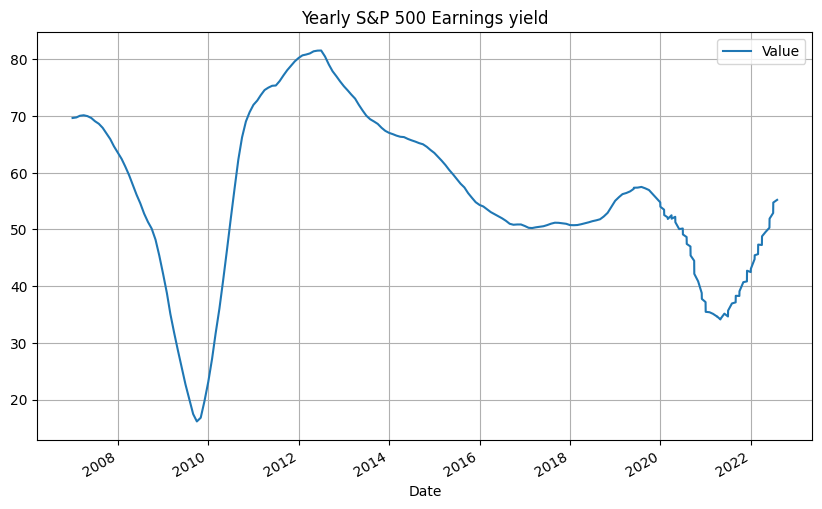

In [26]:

eps_yearly.plot(grid=True, title="Yearly S&P 500 Earnings yield", figsize=(10, 6))

<p>
The yearly earnings does look like it might be a credible market downturn signal.
</p>
<h3>
Unemployment Momentum
</h3>
<p>
Fred Piard writes that unemployment data "is widely broadcasted on fiancial and news websites". This is not much help for someone
who wants to perform quantitative analysis of the unemployment rate as a market signal.
</p>
<p>
United States unemployment rate statistics are published by the US Bureau of Labor Statistics. The data can be downloaded
via a REST interface. To do this, a data ID is required. The data ID is for the seasonally adjusted unemployment rate is:
</p>
<pre>
Data ID: LNS14000000
</pre>
<p>
There is a Python library for accessing the BLS data: <a href="https://pypi.org/project/bls-data/">PyBLS</a>.
This library does not seem to work. The import <pre>from pybls.bls_data import BlsData</pre> shows <pre>bls_data</pre> as
being undefined. Fortunately, the BLS web site publishes sample Python code that does not use the PyBLS API. This code
was used as the basis for developing the BLSData class below.
</p>

In [27]:

class BLSData:
    """
    A class that supports reading data from the Bureau of Labor Statistics (BLS)
    REST end point.

    This code is derived from the code published on the web page:
    https://www.bls.gov/developers/api_python.htm

    See also https://www.bd-econ.com/blsapi.html

    start_year: the numerical year (e.g., 2021) as a string
    end_year: same as start_year  start_year <= end_year

    This class writes the data out to a temp file, so that the file can be read
    in subsequent runs.  This avoids running into the BLS daily download limit.
    This also improves performance.
    """
    def __init__(self, start_year: str, end_year: str):
        self.start_year = start_year
        self.end_year = end_year
        self.unemployment_data_id = 'LNS14000000'
        self.bls_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
        self.headers = {'Content-type': 'application/json'}
        self.max_years = 10
        self.bls_file_name = 'bls_monthly_unemployment.csv'

    def http_request(self, start_year: int, end_year: int) -> str:
        request_json_str = {'seriesid': [self.unemployment_data_id],
                            'startyear': str(start_year),
                            'endyear': str(end_year)}
        request_json = json.dumps(request_json_str)
        http_data = requests.post(self.bls_url, data=request_json, headers=self.headers)
        return http_data.text

    def fetch_data(self, start_year: int, end_year: int) -> pd.DataFrame:
        # The JSON for 'item' in the code below is:
        # {'year': '2016',
        # 'period': 'M12',
        # 'periodName': 'December',
        # 'value': '4.7',
        #  'footnotes': [{}]}
        #
        json_str = self.http_request(start_year, end_year)
        json_dict = jp.decode(json_str)
        status = json_dict['status']
        if status != 'REQUEST_SUCCEEDED':
            raise Exception(json_dict['message'])
        date_l = list()
        value_l = list()
        for series in json_dict['Results']['series']:
            for item in series['data']:
                year = item['year']
                period = item['period']
                value = float(item['value'])
                period_date = datetime(year=int(year), month=int(period[1:]), day=1)
                value_l.append(value)
                date_l.append(period_date)
        period_df = pd.DataFrame(value_l)
        period_df.index = date_l
        # Make sure that dates are in increasing order
        period_df.sort_index(inplace=True)
        return period_df

    def get_unemployment_data_from_bls(self) -> pd.DataFrame:
        start_year_i = int(self.start_year)
        end_year_i = int(self.end_year)
        unemployment_df = pd.DataFrame()
        while start_year_i < end_year_i:
            period_end = min(((start_year_i + self.max_years) - 1), end_year_i)
            period_data_df = self.fetch_data(start_year_i, period_end)
            unemployment_df = pd.concat([unemployment_df, period_data_df], axis=0)
            delta = (period_end - start_year_i) + 1
            start_year_i = start_year_i + delta
        unemployment_df.columns = ['unemployment']
        unemployment_df.index.name = 'Date'
        return unemployment_df

    def get_unemployment_data(self) -> pd.DataFrame:
        temp_root: str = tempfile.gettempdir() + '/'
        file_path: str = temp_root + self.bls_file_name
        temp_file_path = Path(file_path)
        file_size = 0
        if temp_file_path.exists():
            file_size = temp_file_path.stat().st_size

        if file_size > 0:
            unemployment_data_df = pd.read_csv(file_path, index_col='Date')
        else:
            unemployment_data_df = self.get_unemployment_data_from_bls()
            unemployment_data_df.to_csv(file_path)
        return unemployment_data_df


bls_start_year: str = '2007'
bls_end_year: str = str(datetime.today().year)
bls_data = BLSData(bls_start_year, bls_end_year)
#
# Round to a whole number since fractional unemployment values are not very accurate
# (e.g., there is a lot of noise in unemployment numbers)
bls_unemployment_df = round(bls_data.get_unemployment_data(), 0)

<p>
The plot below shows the seasonaly adjusted monthly unemployment data retrieved from the US Bureau of Labor Statistics (BLS)
</p>

<AxesSubplot:title={'center':'Monthly Unemployment Rate (percent)'}, xlabel='Date'>

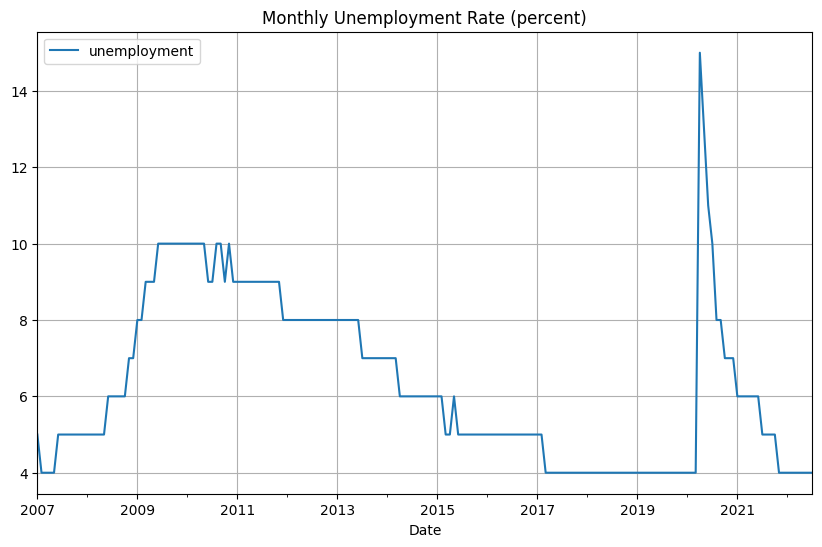

In [28]:

bls_unemployment_df.plot(grid=True, title='Monthly Unemployment Rate (percent)', figsize=(10, 6))
